#Laborator 5

In cadrul acestui laborator vom implementa o solutie de detectie. Datasetul folosit se numeste [American Sign Language Letters Dataset](https://public.roboflow.com/object-detection/american-sign-language-letters/1/download/coco).

In [1]:
!curl -L "https://public.roboflow.com/ds/KamceLFGGS?key=dqp8HADMki" > roboflow.zip; unzip -q roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1446      0 --:--:-- --:--:-- --:--:--  1446
100 22.8M  100 22.8M    0     0  24.1M      0 --:--:-- --:--:-- --:--:--  310M


In [2]:
! ls

README.roboflow.txt  sample_data  test	train  valid


In [3]:
!ls train | grep "json"

_annotations.coco.json


## Crearea Dataloader-ului

In continuare, pentru a incarca date, sa o folosim un obiect mai complex, un Torch.utils.data.Dataset. Acesta are 3 functii importante:


*   __init__()
*   ____len____()
*  ____get_item____()



In [4]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch as t
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import random
from pycocotools.coco import COCO
import os

from torchvision.transforms.functional import to_tensor

random.seed(42)

class HandsDataset(Dataset):
  def __init__(self, coco_root, coco_annos, coco_imgs, img_size=(320, 320)):
    """
    Args:
        dataset_lines (array): array of strings of form "{image_path}|{rectangle_coordinates}".
        width (int): target image width.
        height (int): target image height.
    """
    self.coco_root = coco_root
    self.coco_annos = coco_annos
    self.coco_imgs = coco_imgs

    self.coco_anno_file = os.path.join(coco_root, coco_annos)
    self.coco_imgs_dir = os.path.join(coco_root, coco_imgs)

    self.coco = COCO(self.coco_anno_file)

    self.img_size = img_size

    self.init_dataset()

  def init_dataset(self):
    self.cat_ids = self.coco.getCatIds()

    self.img_ids = self.coco.getImgIds()
    self.ann_ids = self.coco.getAnnIds(self.img_ids)

    print("Dataset size {}".format(len(self.img_ids)))

  def __len__(self):
    return len(self.img_ids)

  def __getitem__(self, idx):
    img_meta = self.coco.loadImgs(self.img_ids[idx])[0]
    img_path = os.path.join(self.coco_imgs_dir, img_meta['file_name'])
    img = Image.open(img_path)
    ann_id = self.coco.getAnnIds(self.img_ids[idx])
    annos = self.coco.loadAnns(ann_id)[0]

    original_width, original_height = img.size

    img = img.resize(self.img_size)
    img = np.array(img)

    if len(img.shape) == 2:
      img = np.expand_dims(img, axis=2)
      img = np.repeat(img, 3, axis=2)

    img = to_tensor(img)

    bbox = annos['bbox']  # box is xywh
    cat_id = annos['category_id']

    x1, y1, w, h = bbox
    x2, y2 = x1 + w, y1 + h

    # x1 = x1 / original_width * self.img_size[0]
    # x2 = x2 / original_width * self.img_size[0]
    # y1 = y1 / original_height * self.img_size[1]
    # y2 = y2 / original_height * self.img_size[1]


    x1 = x1 / original_width
    x2 = x2 / original_width
    y1 = y1 / original_height
    y2 = y2 / original_height

    coordinates = np.array([x1, y1, x2, y2])
    coordinates =  coordinates.astype(np.float32)

    return img, coordinates, cat_id


def test_loader(dataloader: DataLoader):
  for i, (imgs, coordinates, cat_id) in enumerate(dataloader):
    print(i)
    print(coordinates, cat_id)
    # clear_output(wait=True)
    # plt.imshow(imgs[0])

    # x1, y1, x2, y2 = coordinates[0]
    # rect = patches.Rectangle((x1, y1), x2-x1+1, y2-y1+1, linewidth=1, edgecolor='r', facecolor='none')
    # plt.gca().add_patch(rect)
    # plt.show()

    # if i >= see_examples - 1:
    #   break
    # time.sleep(1)

Construire Dataset si vizualizare date.



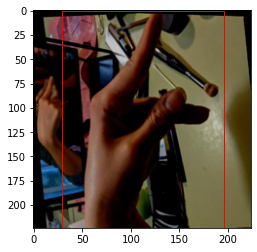

In [5]:
from IPython.display import clear_output
import time

coco_root = ""
coco_anno_train = os.path.join(coco_root, "train/_annotations.coco.json")
coco_imgs_train = os.path.join(coco_root, "train")

coco_anno_valid = os.path.join(coco_root, "valid/_annotations.coco.json")
coco_imgs_valid = os.path.join(coco_root, "valid")

dataset_train = HandsDataset(coco_root, coco_anno_train, coco_imgs_train, img_size=(224, 224))
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=1)

dataset_valid = HandsDataset(coco_root, coco_anno_valid, coco_imgs_valid, img_size=(224, 224))
valid_loader = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=1)

see_examples = 10
for i, (imgs, coordinates, cat_id) in enumerate(train_loader):
    clear_output(wait=True)
    imgs = np.transpose(imgs, (0, 2, 3, 1))

    plt.imshow(imgs[0])

    x1, y1, x2, y2 = coordinates[0]
    x1 = x1 * dataset_train.img_size[1]
    y1 = y1 * dataset_train.img_size[0]
    x2 = x2 * dataset_train.img_size[1]
    y2 = y2 * dataset_train.img_size[0]



    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    plt.show()

    if i >= see_examples - 1:
      break
    time.sleep(1)


# Crearea unei retele neurale convolutionale

### Cerinte
* Creati o arhitectura de retea neuronala convolutionala pentru regresie pe cele 4 coordonate alte imaginilor din dataset.
* Punctaj: 7 puncte pentru o retea cu rezultate *bune*.

#### Hint


  


*   Numarul de exemple de antrenare este prea mic pentru a antrena o retea "from scratch". Folositi o retea prea-antrenata pe ImagetNet, care a invatat deja sa recunoasca trasaturi utile pentru detectia de obiecte. Arhitectura recomandata este ResNet18 din Pytorch. Alte arhitecturi pot fi incercate.
*   La final trebuie utilizata o functie de activare care acopera [0,1]



### Definirea obiectelor folosite in timpul antrenarii

### Cerinte
  * Numarul de epoci
  * Retea
  * Optimizator
  * Functie de loss

Experimentati cu valorile hiper-parametrilor de mai sus astfel incat reteaua sa invete *bine*.

In [6]:
import torchvision.models as models
pretrained = models.resnet18(pretrained=True).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [7]:
import torch.nn as nn
from functools import partial

In [18]:
class MyResNet(nn.Module):
    def __init__(self, my_pretrained_model):
        super(MyResNet, self).__init__()
        self.pretrained = my_pretrained_model
        self.my_new_layers = nn.Sequential(nn.Linear(1000, 100),
                                           nn.ReLU(),
                                           nn.Linear(100, 4),
                                           nn.ReLU())
        self.my_new_layers2 = nn.Sequential(nn.Linear(1000, 100),
                                           nn.ReLU(),
                                           nn.Linear(100, 26),
                                           nn.ReLU())
    
    def forward(self, x):
        x = self.pretrained(x)
        cls = self. my_new_layers2(x)
        x = self.my_new_layers(x)

        return x, cls

my_extended_model = MyResNet(my_pretrained_model=pretrained)
my_extended_model

MyResNet(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
import torch.optim as optim

# Definiti numarul de epoci
epochs = 7

# Definiti reteaua
network = MyResNet(pretrained).cuda()

# Definiti optimizatorul
optimizer = optim.Adam(network.parameters(), lr=1e-4)
# Dupa definirea optimizatorului si dupa fiecare iteratie trebuie apelata functia zero_grad().
# Aceasta face toti gradientii zero.
# Completati codul pentru a face gradientii zero aici


# Definiti functia cost pentru pentru regressie
loss_fn = nn.MSELoss()

## Definirea functiei de antrenare

In [10]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
  # import pdb; pdb.set_trace()
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader, 
             net: torch.nn.Module, loss_fn: torch.nn.Module, optimizer: optim.Optimizer):
  # Iteram prin numarul de epoci
  for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0

    # Iteram prin fiecare exemplu din dataset
    net = net.train()
    for idx, (images, labels, _) in enumerate(train_loader):

      images = images.cuda()
      # Aplicam reteaua neurala pe imaginile de intrare
      out = net(images)
      # Aplicam functia cost pe iesirea retelei neurale si pe adnotarile imaginilor 
      # out = out.cpu()
      loss = loss_fn(out, labels.cuda())
      # Aplicam algoritmul de back-propagation
      loss.backward()
      # Facem pasul de optimizare, pentru a aplica gradientii pe parametrii retelei
      optimizer.step()
      # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
      optimizer.zero_grad()

      train_loss += loss.item()*images.size(0)

    
    # Caluculul acuratetii
    count = len(test_loader)
    IOU_list = []
    net = net.eval()

    for test_image, box_gt, _ in test_loader:
      test_image = test_image.cuda()
      bbox_pred = net(test_image)

      # bbox_pred = bbox_pred.cpu()

      loss = loss_fn(bbox_pred, box_gt.cuda())

      bbox_pred = bbox_pred.detach().cpu().numpy()

      IOU_list.append(bb_intersection_over_union(bbox_pred[0], box_gt[0]))

      valid_loss += loss.item()*test_image.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print(f"Average train loss : {train_loss}")
    print(f"Average valid loss : {valid_loss}")

    IOU_list = np.array(IOU_list)
    IOU_list_50 = (IOU_list > 0.5).sum()
    IOU_list_75 = (IOU_list > 0.75).sum()
    IOU_list_90 = (IOU_list > 0.90).sum()

    print("Acuratetea IOU 50% la finalul epocii {} este {:.2f}%".format(e, (IOU_list_50 / count) * 100))
    print("Acuratetea IOU 75% la finalul epocii {} este {:.2f}%".format(e, (IOU_list_75 / count) * 100))
    print("Acuratetea IOU 90% la finalul epocii {} este {:.2f}%".format(e, (IOU_list_90 / count) * 100))


In [11]:
train_fn(epochs, train_loader, valid_loader, network, loss_fn, optimizer)

Average train loss : 0.05739730438858113
Average valid loss : 0.021119590776328953
Acuratetea IOU 50% la finalul epocii 0 este 99.31%
Acuratetea IOU 75% la finalul epocii 0 este 50.69%
Acuratetea IOU 90% la finalul epocii 0 este 5.56%
Average train loss : 0.01268679012480394
Average valid loss : 0.00950457947823856
Acuratetea IOU 50% la finalul epocii 1 este 100.00%
Acuratetea IOU 75% la finalul epocii 1 este 90.97%
Acuratetea IOU 90% la finalul epocii 1 este 9.72%
Average train loss : 0.006225567476124202
Average valid loss : 0.006916518114141784
Acuratetea IOU 50% la finalul epocii 2 este 100.00%
Acuratetea IOU 75% la finalul epocii 2 este 90.97%
Acuratetea IOU 90% la finalul epocii 2 este 23.61%
Average train loss : 0.004180911480000726
Average valid loss : 0.0064596271998501225
Acuratetea IOU 50% la finalul epocii 3 este 100.00%
Acuratetea IOU 75% la finalul epocii 3 este 94.44%
Acuratetea IOU 90% la finalul epocii 3 este 18.75%
Average train loss : 0.0031426861683872564
Average va

## Augmentare date

O metoda foarte buna pentru a creste performanta modelului este augmentarea setului de date. Aceste augmentari trebuie sa tina cont de natura taskului si de natura etichetelor.

### Cerinta

(3p) Modificati dataloaderul precedent astfel incat sa augmenteze datele de train cu o probabilitate aleasa de voi. Cum afecteaza acest lucru performanta modelului?

### Bonus
(2p) Dataloaderul intoarce si clasa fiecarui obiect de detectat (litera corespunzatoare fiecarui semn din limbajul Sign Language). Creati o arhitectura care prezice si acesta clasa, pe langa regresia pe box. Antrenati reteaua. 

In [12]:
import string
letters = string.ascii_uppercase


In [13]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch as t
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import random
from pycocotools.coco import COCO
import os

from torchvision.transforms.functional import to_tensor

random.seed(42)

class HandsDataset(Dataset):
  def __init__(self, coco_root, coco_annos, coco_imgs, img_size=(320, 320), transformer = None):
    """
    Args:
        dataset_lines (array): array of strings of form "{image_path}|{rectangle_coordinates}".
        width (int): target image width.
        height (int): target image height.
    """
    self.coco_root = coco_root
    self.coco_annos = coco_annos
    self.coco_imgs = coco_imgs
    self.transformer = transformer
    self.coco_anno_file = os.path.join(coco_root, coco_annos)
    self.coco_imgs_dir = os.path.join(coco_root, coco_imgs)

    self.coco = COCO(self.coco_anno_file)

    self.img_size = img_size

    self.init_dataset()

  def init_dataset(self):
    self.cat_ids = self.coco.getCatIds()

    self.img_ids = self.coco.getImgIds()
    self.ann_ids = self.coco.getAnnIds(self.img_ids)

    print("Dataset size {}".format(len(self.img_ids)))

  def __len__(self):
    return len(self.img_ids)

  def __getitem__(self, idx):
    img_meta = self.coco.loadImgs(self.img_ids[idx])[0]
    img_path = os.path.join(self.coco_imgs_dir, img_meta['file_name'])
    img = Image.open(img_path)
    ann_id = self.coco.getAnnIds(self.img_ids[idx])
    annos = self.coco.loadAnns(ann_id)[0]

    original_width, original_height = img.size

    img = img.resize(self.img_size)
    img = np.array(img)

    if len(img.shape) == 2:
      img = np.expand_dims(img, axis=2)
      img = np.repeat(img, 3, axis=2)
    
    if self.transformer:
      img = np.transpose(img, (2,0,1))
      img = self.transformer(torch.tensor(img)).numpy() # permuting for numpy(PIL) - torch compatibility
      img = np.transpose(img,(1,2,0))
    img = to_tensor(img)
    #normalized_img = normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #print(img)
    bbox = annos['bbox']  # box is xywh
    cat_id = annos['category_id']

    x1, y1, w, h = bbox
    x2, y2 = x1 + w, y1 + h

    # x1 = x1 / original_width * self.img_size[0]
    # x2 = x2 / original_width * self.img_size[0]
    # y1 = y1 / original_height * self.img_size[1]
    # y2 = y2 / original_height * self.img_size[1]


    x1 = x1 / original_width
    x2 = x2 / original_width
    y1 = y1 / original_height
    y2 = y2 / original_height

    coordinates = np.array([x1, y1, x2, y2])
    coordinates =  coordinates.astype(np.float32)

    return img, coordinates, cat_id


def test_loader(dataloader: DataLoader):
  for i, (imgs, coordinates, cat_id) in enumerate(dataloader):
    print(i)
    print(coordinates, cat_id)
    # clear_output(wait=True)
    # plt.imshow(imgs[0])

    # x1, y1, x2, y2 = coordinates[0]
    # rect = patches.Rectangle((x1, y1), x2-x1+1, y2-y1+1, linewidth=1, edgecolor='r', facecolor='none')
    # plt.gca().add_patch(rect)
    # plt.show()

    # if i >= see_examples - 1:
    #   break
    # time.sleep(1)

In [14]:
from torchvision import transforms
transforms_random = transforms.RandomApply(torch.nn.ModuleList([
     transforms.ColorJitter(0.2,0.2,0.2,0.2),
]), p=0.2)
composite_random = transforms.Compose([
    transforms_random
])

dataset_train = HandsDataset(coco_root, coco_anno_train, coco_imgs_train, img_size=(224, 224),transformer=transforms_random)
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=4)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Dataset size 1512


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([0.1146, 0.2415, 0.7065, 0.8127])
E


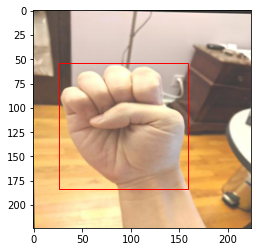

In [15]:
for i, (imgs, coordinates, cat_id) in enumerate(train_loader):
    clear_output(wait=True)
    imgs = np.transpose(imgs, (0, 2, 3, 1))

    print(coordinates[0])
    print(letters[int(cat_id[0])-1])
    plt.imshow(imgs[0])

    x1, y1, x2, y2 = coordinates[0]
    x1 = x1 * dataset_train.img_size[1]
    y1 = y1 * dataset_train.img_size[0]
    x2 = x2 * dataset_train.img_size[1]
    y2 = y2 * dataset_train.img_size[0]



    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    plt.show()

    if i >= see_examples - 1:
      break
    time.sleep(1)

In [16]:
import torch.optim as optim

# Definiti numarul de epoci
epochs =13

# Definiti reteaua
network = MyResNet(pretrained).cuda()

# Definiti optimizatorul
optimizer = optim.Adam(network.parameters(), lr=5e-4)
# Dupa definirea optimizatorului si dupa fiecare iteratie trebuie apelata functia zero_grad().
# Aceasta face toti gradientii zero.
# Completati codul pentru a face gradientii zero aici


# Definiti functia cost pentru pentru regressie
loss_fn = nn.MSELoss()

In [17]:
train_fn(epochs, train_loader, valid_loader, network, loss_fn, optimizer)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Average train loss : 0.02905510066116534
Average valid loss : 0.0041513337798985755
Acuratetea IOU 50% la finalul epocii 0 este 100.00%
Acuratetea IOU 75% la finalul epocii 0 este 99.31%
Acuratetea IOU 90% la finalul epocii 0 este 37.50%
Average train loss : 0.003978729308410375
Average valid loss : 0.002682260265121133
Acuratetea IOU 50% la finalul epocii 1 este 100.00%
Acuratetea IOU 75% la finalul epocii 1 este 99.31%
Acuratetea IOU 90% la finalul epocii 1 este 55.56%
Average train loss : 0.0033010453929405207
Average valid loss : 0.0028723986877392032
Acuratetea IOU 50% la finalul epocii 2 este 100.00%
Acuratetea IOU 75% la finalul epocii 2 este 99.31%
Acuratetea IOU 90% la finalul epocii 2 este 49.31%
Average train loss : 0.0032791187580201832
Average valid loss : 0.0035008786310047274
Acuratetea IOU 50% la finalul epocii 3 este 100.00%
Acuratetea IOU 75% la finalul epocii 3 este 99.31%
Acuratetea IOU 90% la finalul epocii 3 este 36.81%
Average train loss : 0.002915795337502406
Av

Best results :

on epoch 12

epochs =13

network = MyResNet(pretrained).cuda()

optimizer = optim.Adam(network.parameters(), lr=5e-4)

loss_fn = nn.MSELoss()




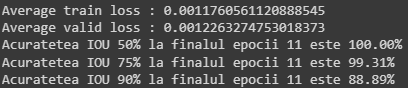
